In [2]:
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from timeit import timeit
from statsmodels.stats.proportion import proportion_confint
import itertools

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Bootstrap

Цель данного ноутбука - реализовать bootstrap, протестировать его работоспособность на синтетических данных,  
сравнить различные бутстрепные доверительные интервалы, а так же реализовать пуассоновский бутстреп и понять, чем он отличается от обычного

Идея бутстрепа максимально проста: пусть у нас есть выборка достаточно большого размера, чтобы хорошо отражать генеральную совокупность.  
Чтобы оценить какую-либо статистику данной выборки сгенерируем из выборки B выборок такого же размера  
путем выбора значений из генеральной выборки с повторением и посчитаем значение статистики по ним,  
после чего построим один из возможных доверительных интервалов.
Давайте это реализуем.

In [4]:
def bootstrap(X: np.array, B: int, stat=np.mean):
    '''
        Функция принимает на выход выборку X, количество бутстрепных выборок B, 
        оцениваемую статистику stat, возвращает бутстрепную оценку статистики и бутстрепные значения статистики
    '''
    est = stat(X)
    b_est = stat(np.random.choice(X, size=(B, X.size), replace=True), axis=1)
    return est, b_est

Для бутстрепных оценок существует несколько доверительных интервалов, реализуем их и сравним.

*Нормальный интервал*  
Формула:    
$(\hat{\theta} \pm z_{\alpha / 2}\sqrt{\hat{v}_{boot}})$  , где  
$\hat{\theta}$ - A.Н.О статистика,  
$\hat{v}_{boot}$ - бутстрепная оценка дисперсии статистики  
Данный интервал работает хорошо, когда распределение статистики близко к нормальному.

In [6]:
def get_normal_interval(X: np.array, B: int, stat, b_est=None, alpha=0.05):
    '''
        Функция принимает на выход выборку X, количество бутстрепных выборок B, 
        оцениваемую статистику stat и уровень значимости alpha
        Возвращает бутстрепный нормальный доверительный интервал для статистики
    '''
    if b_est is None:
        _, b_est = bootstrap(X=X, B=B, stat=stat)
    est = stat(X)
    sd = np.std(b_est)
    q = sps.norm.ppf(1 - alpha / 2)
    return (est - q * sd, est + q * sd)

*Центральный интервал*  
Формула:  
$(2\hat{\theta} - \theta^*_{\lceil B(\alpha / 2) \rceil}, 2\hat{\theta} - \theta^*_{\lfloor B(1 - \alpha / 2) \rfloor})$, где  
$\theta^*_1, ..., \theta^*_B$ - оценки по бутстрепным выборкам

In [7]:
def get_central_interval(X: np.array, B: int, stat, b_est=None, alpha=0.05):
    '''
        Функция принимает на выход выборку X, количество бутстрепных выборок B, 
        оцениваемую статистику stat и уровень значимости alpha
        Возвращает бутстрепный центральный доверительный интервал для статистики
    '''
    if b_est is None:
        _, b_est = bootstrap(X=X, B=B, stat=stat)
    est = stat(X)
    q1, q2 = np.quantile(b_est, 1 - alpha / 2, method='higher'), np.quantile(b_est, alpha / 2, method='lower')
    return (2 * est - q1, 2 * est - q2)

*Квантильный интервал*  
Формула:  
$(\theta^*_{\lfloor B(\alpha / 2) \rfloor}, \theta^*_{\lceil B(1 - \alpha / 2) \rceil})$, где  
$\theta^*_1, ..., \theta^*_B$ - оценки по бутстрепным выборкам

In [8]:
def get_percentile_interval(X: np.array, B: int, stat, b_est=None, alpha=0.05):
    '''
        Функция принимает на выход выборку X, количество бутстрепных выборок B, 
        оцениваемую статистику stat и уровень значимости alpha
        Возвращает бутстрепный квантильный доверительный интервал для статистики
    '''
    if b_est is None:
        _, b_est = bootstrap(X=X, B=B, stat=stat)
    q1, q2 = np.quantile(b_est, alpha / 2, method='lower'), np.quantile(b_est, 1 - alpha / 2, method='higher')
    return (q1, q2)

In [9]:
all_intervals = [get_normal_interval, get_central_interval, get_percentile_interval]
all_interval_labels = ['normal', 'central', 'percentile']

In [44]:
def draw_stat_distr(est, p_est, intervals, interval_labels, size, B, real_val=None, palette=['y', 'b', 'g']):

    x_min, x_max = float('inf'), -float('inf')
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(nrows=len(interval_labels), ncols=1, figsize=(8, 12))
        for i, interval_label in enumerate(interval_labels):
            x_min = min(x_min, intervals['lower_' + interval_label][-1])
            x_max = max(x_max, intervals['upper_' + interval_label][-1])
            axes[i].axvline(x=intervals['lower_' + interval_label][-1], color=palette[i], linestyle='--', label=interval_label + ' interval')
            axes[i].axvline(x=intervals['upper_' + interval_label][-1], color=palette[i], linestyle='--')
            if not (real_val is None):
                axes[i].scatter(real_val, 0, c='purple', marker='*', s=100, label='реальное значение статистики')
            axes[i].scatter(p_est, 0, c='orange', marker='o', s=100, label='точечная оценка статистики')
            axes[i].set_title('{} interval'.format(interval_label))
            axes[i].legend()

        k = 0.25
        for ax in axes:
            sns.histplot(est, ax=ax, stat='density', bins=100, alpha=0.3, color='r', label='гистограмма статистики')
            sns.kdeplot(est, ax=ax, color='r', label='kde статистики')
            ax.set_xlim(x_min - k * (x_max - x_min), x_max + k * (x_max - x_min))
            ax.set_ylim(-0.5, None)
        plt.suptitle('Распределение бутстрепных оценок статистики и доверительные интервалы для нее, \n \
                размер генеральной совокупности: {}, количество бутстрепных выборок: {}'.format(size, B))
    plt.show()

In [45]:
def draw_intervals(distr, bootstrap_=bootstrap, min_sample_size=3, max_sample_size=1000, stat=np.mean, intervals=all_intervals, interval_labels=all_interval_labels, B=1000, real_val=None, draw_stat_distribution=True):
    b_intervals = dict()
    for interval_label in interval_labels:
        b_intervals['lower_' + interval_label] = []
        b_intervals['upper_' + interval_label] = []
    
    b_est = []
    X = distr.rvs(size=max_sample_size)
    for sample_size in tqdm(range(min_sample_size, max_sample_size + 1)):
        est, b_est_ = bootstrap_(X[:sample_size], B, stat)
        if sample_size == max_sample_size:
            last_b_est = b_est_
            last_est = est
        b_est.append(est)
        for i, interval in enumerate(intervals):
            lower, upper = interval(X[:sample_size], B=B, stat=stat, b_est=b_est_)
            b_intervals['lower_' + interval_labels[i]].append(lower)
            b_intervals['upper_' + interval_labels[i]].append(upper)
    
    plt.figure(figsize=(12, 8))
    plt.title('Зависимость доверительного интервала и оценки от размера генеральной совокупности')
    for label in interval_labels:
        plt.fill_between(x=np.arange(min_sample_size, max_sample_size + 1),
                        y1=b_intervals['lower_' + label],
                        y2=b_intervals['upper_' + label],
                        alpha=0.5,
                        label=label
                        )
    plt.plot(np.arange(min_sample_size, max_sample_size + 1),
           b_est,
           label='Выборочная оценка статистики',
           c='r'
           )
    if not (real_val is None):
        plt.axhline(y=real_val,
                linestyle='--',
                label='Реальное значение статистики',
                c='b'
            )

    
    plt.xlabel('Размер генеральной совокупности')
    plt.ylabel('Значение')
    est, sd = np.mean(b_est), np.std(b_est)
    k = 5
    plt.ylim((est - k * sd, est + k * sd))
    plt.legend()
    plt.show()

    if draw_stat_distribution:
        draw_stat_distr(last_b_est, last_est, b_intervals, interval_labels, size=max_sample_size, B=B, real_val=real_val)

100%|██████████| 998/998 [00:12<00:00, 78.35it/s] 


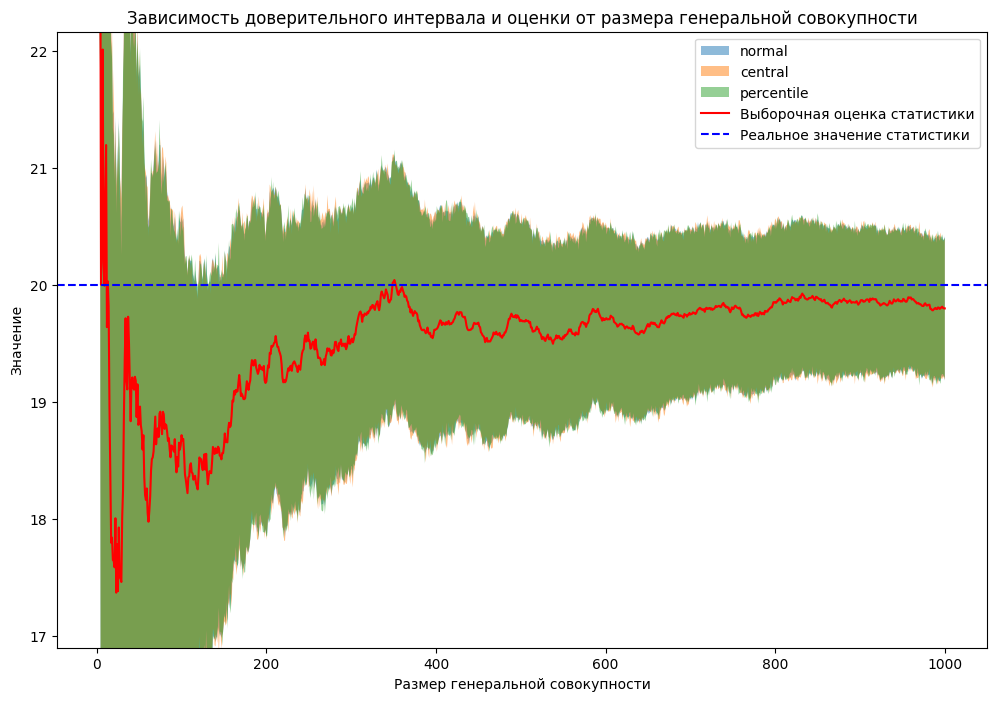

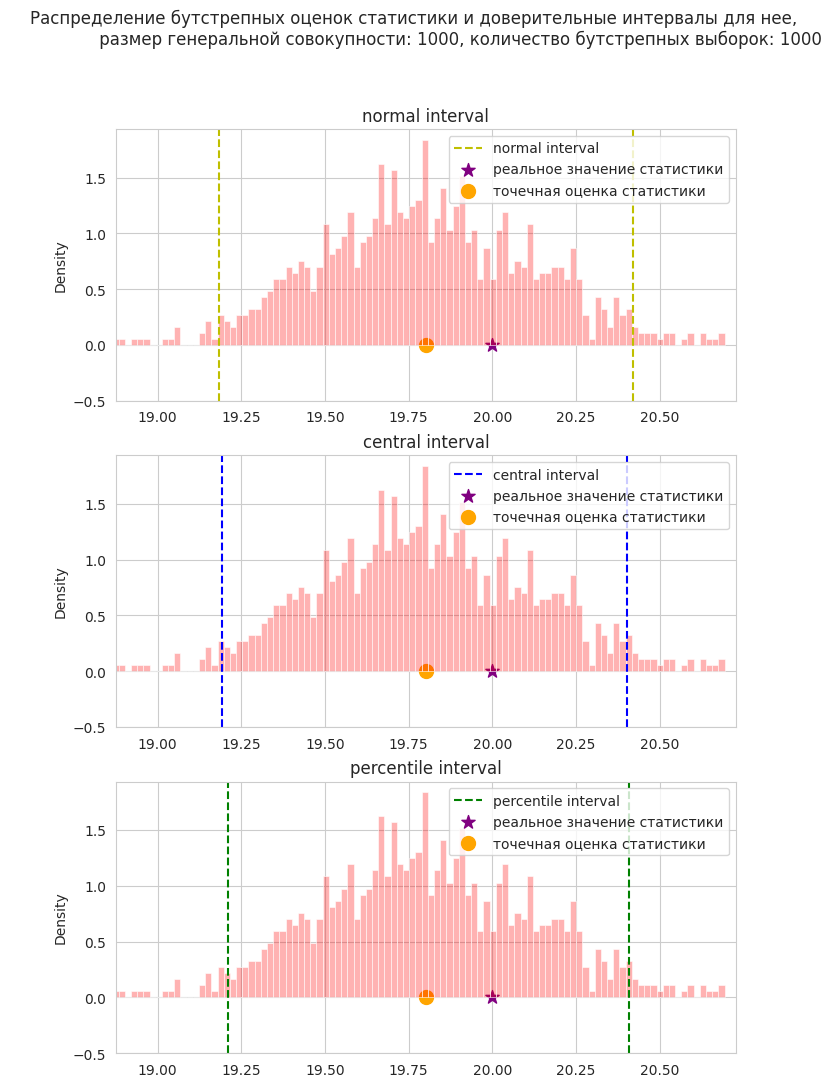

In [326]:
draw_intervals(sps.norm(20, 10), lambda x, b, s: bootstrap(X=x, B=b, stat=s), stat=np.mean, max_sample_size=1000, B=1000, real_val=20)

В случае оценки среднего нормального распределения все доверительные интервалы практически идентичны. Давайте попробуетм оценить более сложную статистику, а именно дисперсию экспоненциального распределения

  0%|          | 0/998 [00:00<?, ?it/s]

100%|██████████| 998/998 [00:16<00:00, 61.46it/s] 


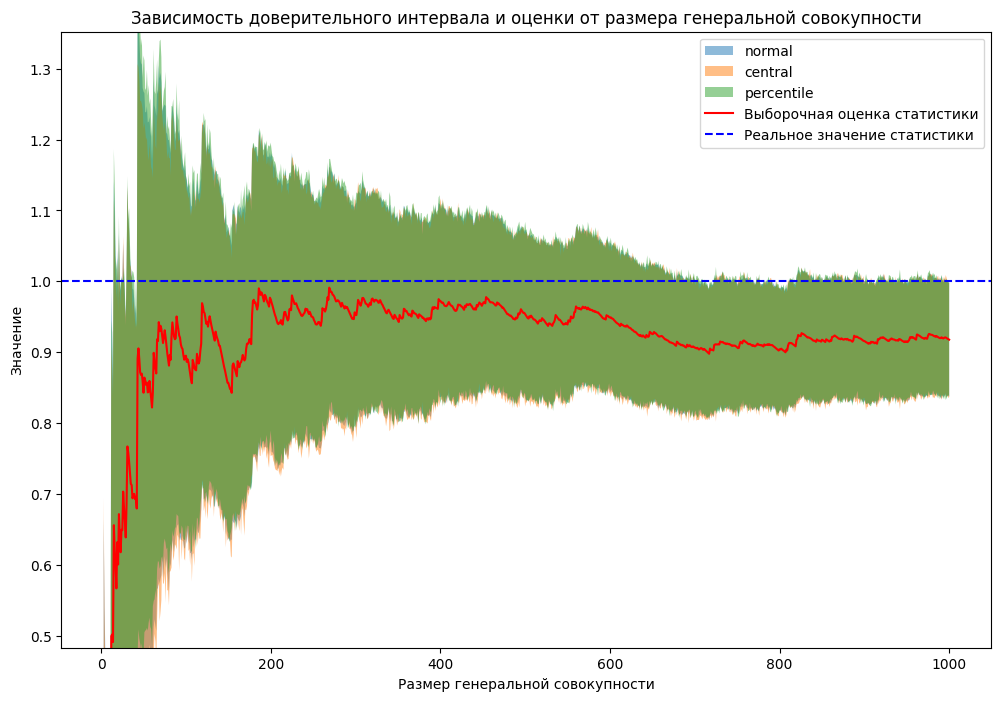

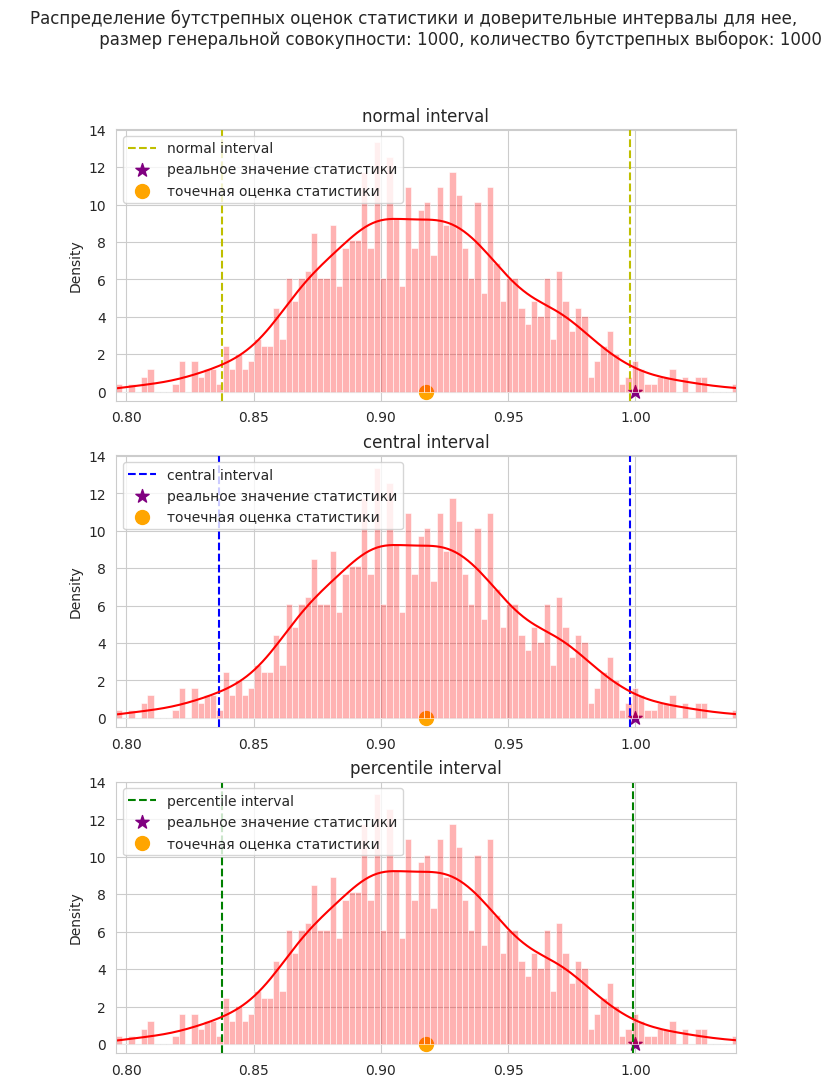

In [46]:
draw_intervals(sps.norm, lambda x, b, s: bootstrap(X=x, B=b, stat=s), max_sample_size=1000, B=1000, stat=np.var, real_val=1)
#restart

Здесь распределение статиски так же близко к нормальному и доверительные интервалы дают практически одинаковый результат. Попробуем еще менее тривиальную статистику - 0.9-квантиль

100%|██████████| 998/998 [00:27<00:00, 36.33it/s] 


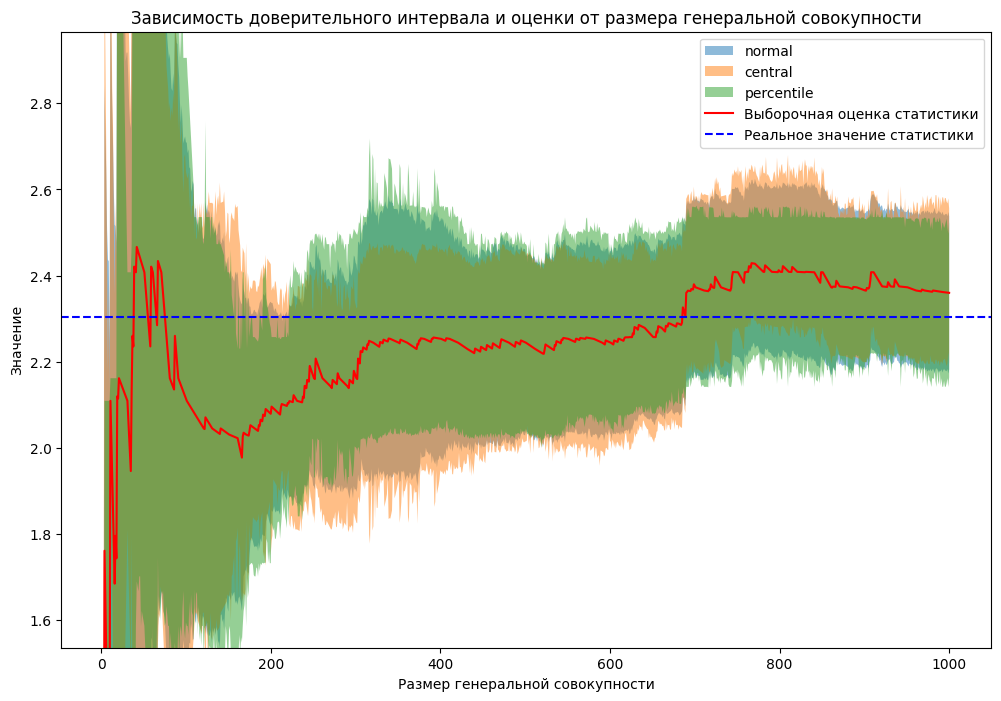

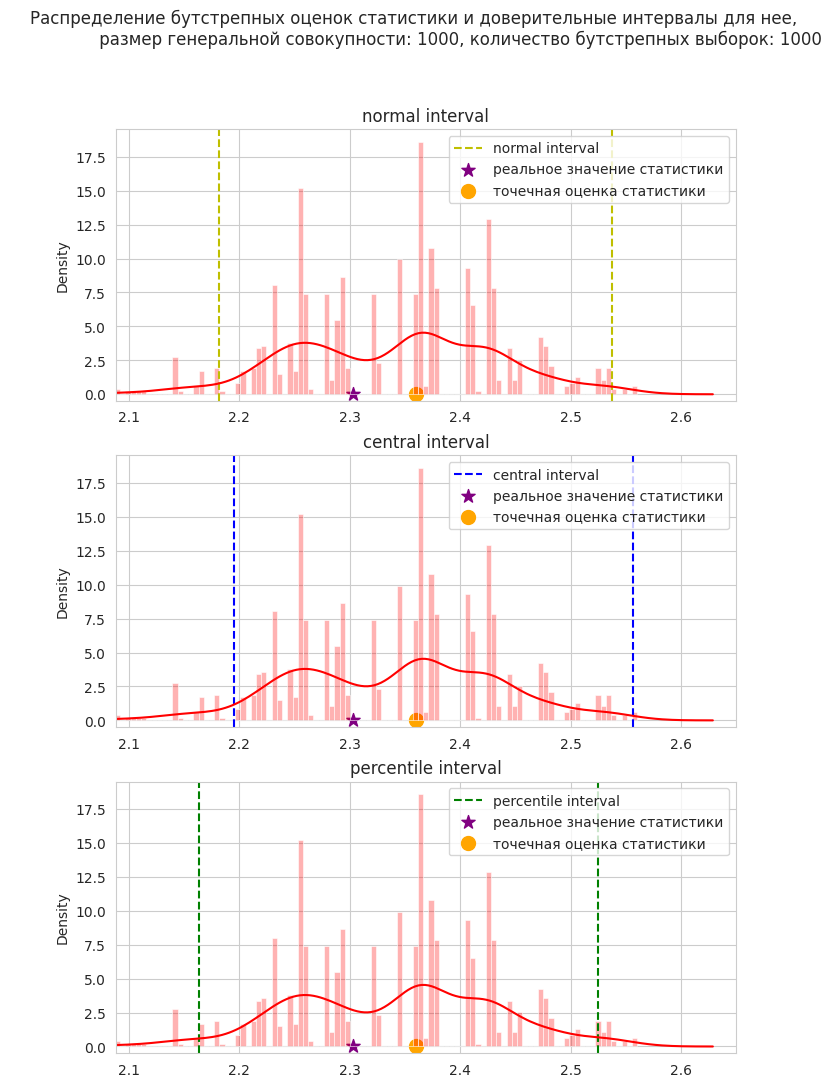

In [203]:
draw_intervals(sps.expon, lambda x, b, s: bootstrap(X=x, B=b, stat=s), max_sample_size=1000, B=1000, stat=lambda x, axis=None: np.quantile(x, 0.9, axis=axis), real_val=sps.expon.ppf(0.9))

Интервалы значительно отличаются, однако видны пропуски в гистограмме, скорее всего для оценки квантиля нужно брать больший размер генеральный совокупности или больше выборок.

Давайте попробуем найти пример, при котором интервалы отличаются еще сильнее при корректных данных

In [12]:
def destroy_intervals(x, axis=None):
    mean = np.mean(x, axis)
    return np.abs(mean)

100%|██████████| 998/998 [00:12<00:00, 78.81it/s] 


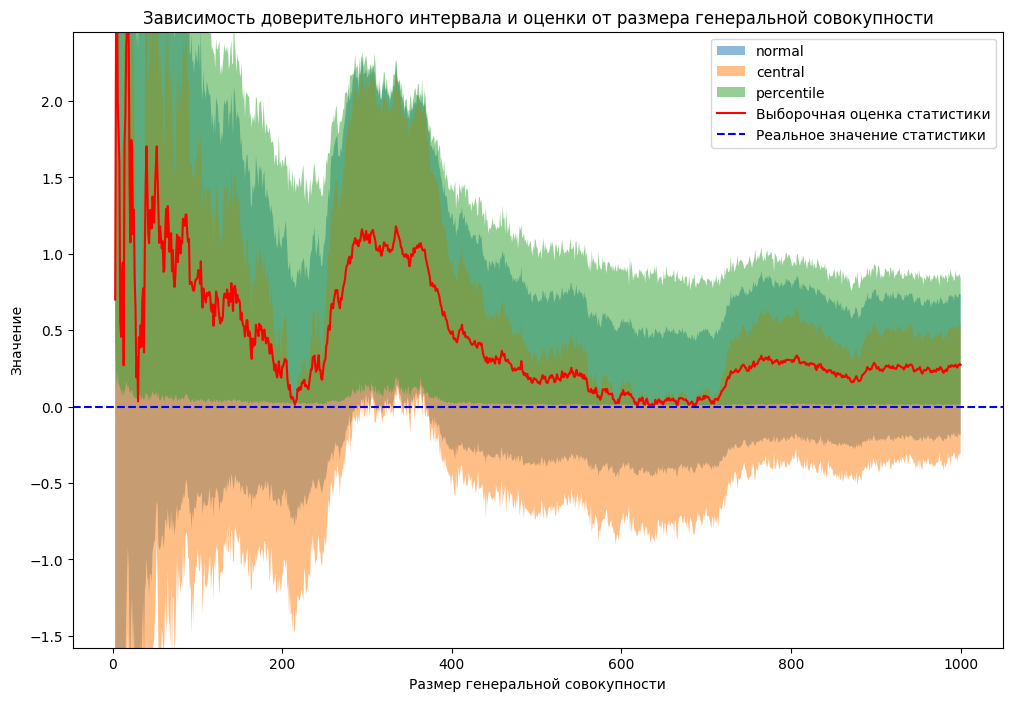

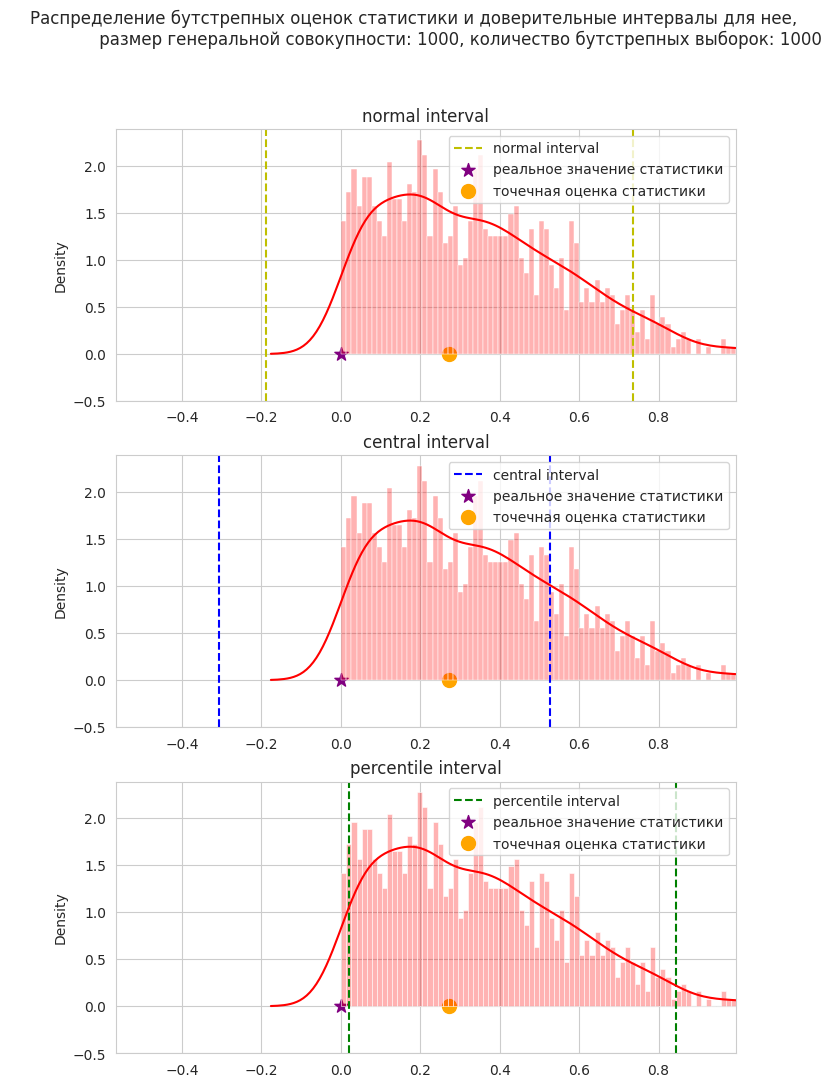

In [284]:
draw_intervals(sps.norm(0, 10), max_sample_size=1000, B=1000, stat=destroy_intervals, real_val=0)

Теперь в нормальный доверительный интервал так же входит зона, в которой теоретически не может лежать значение нашей статистики.  
Заметим так же, что мы сломали и центральный доверительный интерва, в то время как квантильный интервал работает корректно.  
При этом видно, что правые границы интервалов сильно отличаются, что намекает на то, что в данном случае какие-то из интервалов на самом деле некорректны,  
однако на графиках у нас лишь частное наблюдение - чтобы подтвердить опасения необходимо провести процедуру много раз, что мы обязательно и сделаем позже.  
А пока давайте попробуем считать бутстрепные доверительные интервалы побыстрее, чтобы не ждать построения сложных графиков часами.

*Пуассоновский бутстреп*  
    Главной проблемой бутстрепа является время его работы: при большом количестве данных бутстрепный доверительный интервал можно считать очень долго, что может нас не устраивать. Как же мы можем ускорить наши вычисления? Давайте попробуем не брать выборки из мультиномиального распределения, а подсчитать для каждого элемента сколько раз он содержится в каждой бутстрепной выборке.  
    Понятно, что количество попаданий конкретного элемента в бутстрепную выборку равно количеству успехов при подбрасывании монетки N раз с вероятностью успеха 1/N, где N - размер генеральной совокупности. При этом $Bin(N, \frac{1}{N})$ хорошо апроксимируется $Poisson(1)$ уже при N > 100. Давайте воспользуемся этой идеей и попытаемся ускорить наши вычисления.


In [19]:
def poisson_bootstrap(X: np.array, B: int, stat=np.mean, poiss=None):
    '''
        Функция принимает на выход выборку X, количество бутстрепных выборок B, 
        оцениваемую статистику stat, возвращает бутстрепную оценку статистики и бутстрепные значения статистики
    '''
    est = stat(X)
    if poiss is None:
        w = sps.poisson(1).rvs(size=(B, X.size))
    else:
        w = poiss[:B, :X.size]

    b_est = np.array([stat(np.repeat(X, w[i])) for i in range(B)])
    return est, b_est

Так как теперь мы считаем лишь количетсво включений элементов в бутстрепные выборки, то для того, чтобы получить сами выборки нам необходимо их восстановить.  
Это делается в цикле и занимает довольно долго времени.  
В слаке singularis.io мне подсказали, что статистики вида E(g(x)) можно считать и без непостредственного получения выборок.  
Давайте это тоже реализуем, а затем сравним время работы всех вариантов.

In [18]:
def poisson_bootstrap_fast(X: np.array, B: int, stat=np.mean, stat_fast=lambda x, w, axis=1: np.mean(x * w, axis=axis), poiss=None):
    '''
        Функция принимает на выход выборку X, количество бутстрепных выборок B, 
        оцениваемую статистику stat, возвращает бутстрепную оценку статистики и бутстрепные значения статистики
    '''
    est = stat(X)
    if poiss is None:
        w = sps.poisson(1).rvs(size=(B, X.size))
    else:
        w = poiss[:B, :X.size]

    b_est = stat_fast(X, w)
    return est, b_est

In [65]:
def compare_time(distr, distr_label, N, B, stat, stat_fast, stat_label, repeats=1):
    X = distr.rvs(size=N)

    times = [timeit(lambda: bootstrap(X, B, stat), number=repeats), 
             timeit(lambda: poisson_bootstrap(X, B, stat), number=repeats), 
             timeit(lambda: poisson_bootstrap(X, B, stat, poiss=precalc_poisson), number=repeats), 
             timeit(lambda: poisson_bootstrap_fast(X, B, stat, stat_fast, poiss=precalc_poisson), number=repeats)
             ]
    labels = ['Обычный', 
              'Пуассоновский\n без предподсчета распределения', 
              'Пуассоновский с предподсчетом',
              'Пуассоновский с предподсчетом \nи быстрым вычисленем статистик']
    plot_data = {'time': times, 'labels': labels}
    
    with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
        plt.figure(figsize=(10, 6))
        sns.barplot(x='time', y='labels', data=plot_data, palette=sns.color_palette(), alpha=0.9)
        plt.xlabel('Среднее время работы в секундах')
        plt.ylabel('Тип бутстрепа')
        plt.xticks(np.arange(0, max(times) * 1.05, 0.05 if max(times) < 1 else 2))
        plt.title('Сравнение времени работы различных реализация бутстрепа. Распределение генеральной совокупности: {} \n размер совокупности: {}, количество бутстрепных выборок: {}, статистика: {}'.format(distr_label, N, B, stat_label))
        plt.show()

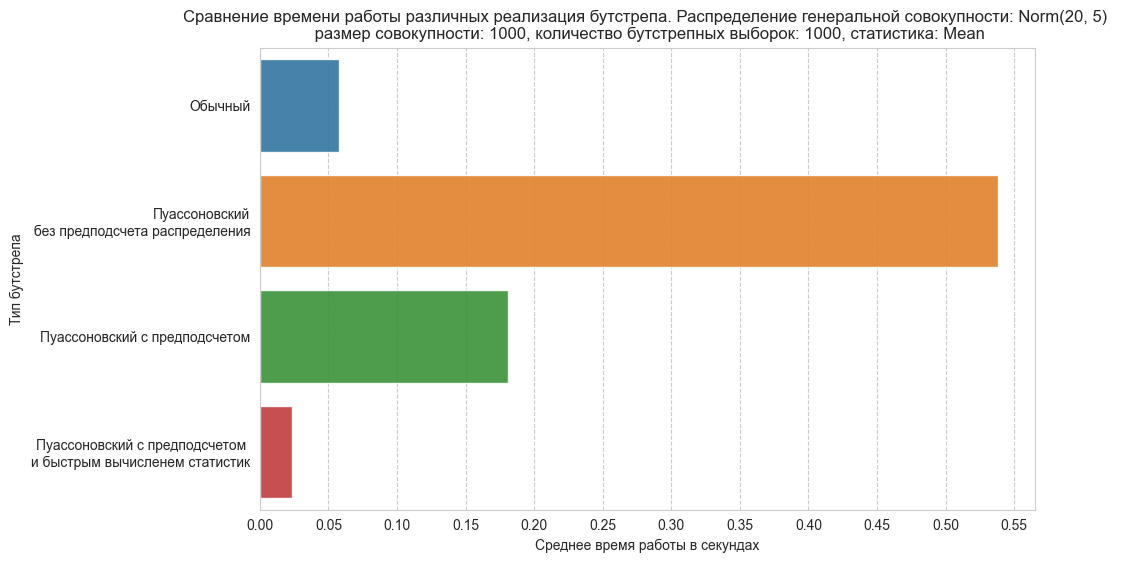

In [66]:
N = 10 ** 3
B = 10 ** 3
stat = np.mean
stat_fast_mean = lambda x, w, axis=1: np.mean(x * w, axis=axis)

compare_time(sps.norm(20, 5), r'Norm(20, 5)', N, B, stat=stat, stat_fast=stat_fast_mean, stat_label='Mean', repeats=7)

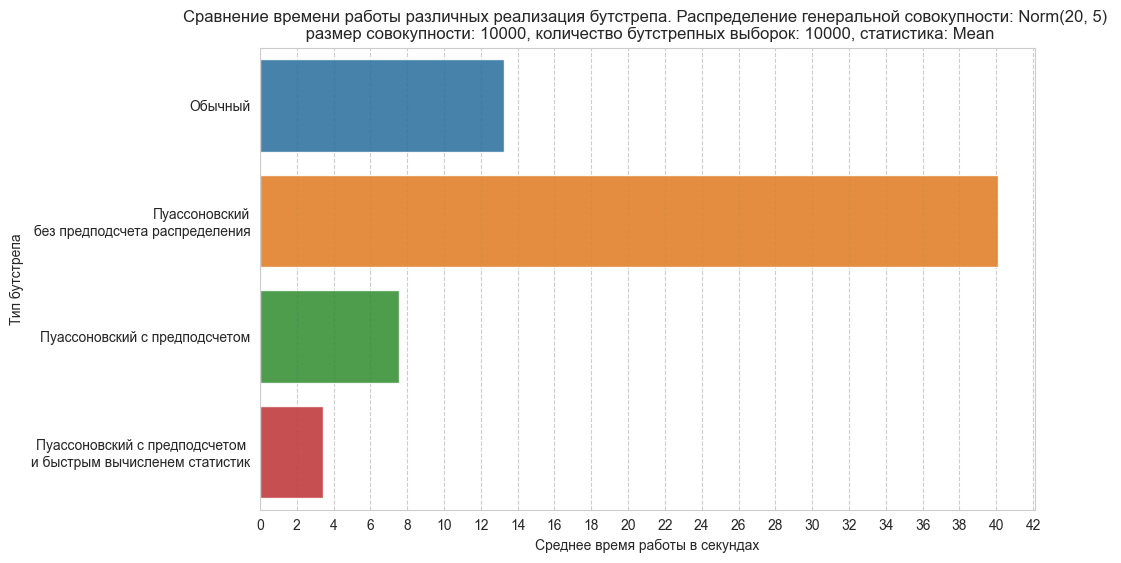

In [67]:
N = 10 ** 4
B = 10 ** 4
stat = np.mean
stat_fast_mean = lambda x, w, axis=1: np.mean(x * w, axis=axis)

compare_time(sps.norm(20, 5), r'Norm(20, 5)', N, B, stat=stat, stat_fast=stat_fast_mean, stat_label='Mean', repeats=5)

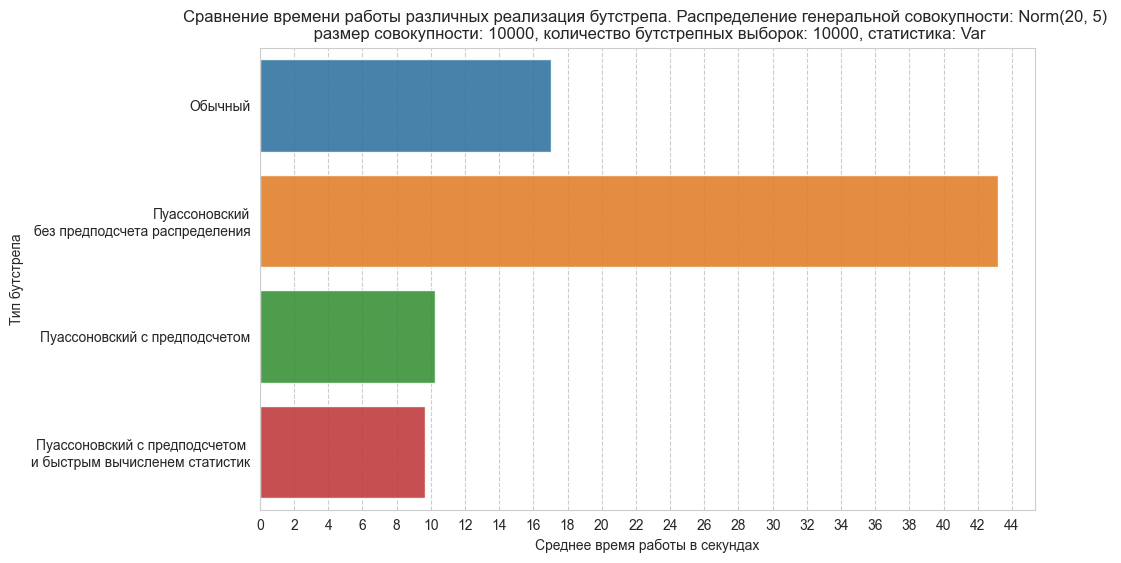

In [69]:
N = 10 ** 4
B = 10 ** 4
stat = np.var
stat_fast_var = lambda x, w, axis=1: np.mean(np.square(x) * w, axis=axis) - np.square(np.mean(x * w, axis=axis))

compare_time(sps.norm(20, 5), r'Norm(20, 5)', N, B, stat=stat, stat_fast=stat_fast_var, stat_label='Var', repeats=5)

Нам удалось увеличить скорость подсчета бутстрепа в 2-4 раза в зависимости от статистики, размера совокупности и количества бутстрепных выборок.  
Если нужно подсчитать, например, 0.9-квантиль, то ускорение будет меньше, так как простыми векторными операциями его посчитать не получится.  
На больших данных ускорение скорее всего будет еще более значимым, но протестить это на ноуте проблематично из-за ограничений по памяти.

Со временем разобрались, теперь заметим, что при генерации бутстрепных выборок при помощи пуассоновского распределения их размеры могут отличаться от размера исходной выборки.  
В связи с этим может расти дисперсия бутстрепных оценок статистики, что очевидным образом влияет на доверительные интервалы -> может измениться уровень доверия.  
Давайте сначала посмотрим на распределение бутстрепных оценок при использовании разных бутстрепов, а затем проверим корректность обычного и пуассоновского бутстрепа при проведении теста.

In [73]:
def draw_b_est_distr(b_est, labels, size, B, distr, stat, alpha=0.05, palette1=['green', 'blue'], palette2=['pink', 'purple']):
    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(10, 6))
        for i, b_est_ in enumerate(b_est):
            sns.histplot(b_est_, stat='density', alpha=0.3, color=palette1[i], label=labels[i])
            sns.kdeplot(b_est_, color=palette1[i], label=f'kde {labels[i]}')
            plt.axvline(x=np.quantile(b_est_, alpha / 2), linestyle='--', c=palette2[i],label=r'$\alpha/2$-квантиль {}'.format(labels[i]))
            plt.axvline(x=np.quantile(b_est_, 1 - alpha / 2), linestyle='--', c=palette2[i], label=r'$1 - \alpha / 2$-квантиль {}'.format(labels[i]))
        plt.title(f'Бутстрепные оценки, исходное распределение: {distr}, \n размер исходной выборки: {N}, количество бутстрепных выборок: {B}, оцениваемая статистика: {stat}')
        plt.rc('legend', fontsize=8)
        plt.legend()
        plt.show()

In [11]:
precalc_poisson = sps.poisson(1).rvs(size=(10 ** 4, 10 ** 4))

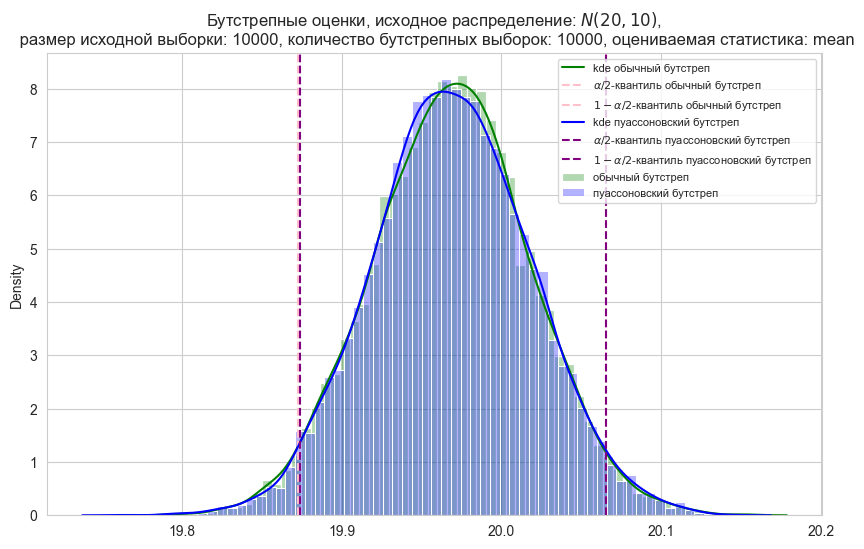

In [74]:
N = 10 ** 4
B = 10 ** 4
X = sps.norm(20, 5).rvs(size=N)

stat = np.mean
_, b_est = bootstrap(X, B, stat)
_, p_b_est = poisson_bootstrap(X, B, stat, precalc_poisson)
draw_b_est_distr([b_est, p_b_est], labels=['обычный бутстреп', 'пуассоновский бутстреп'], size=N, B=B, distr=r'$N(20, 10)$', stat='mean')

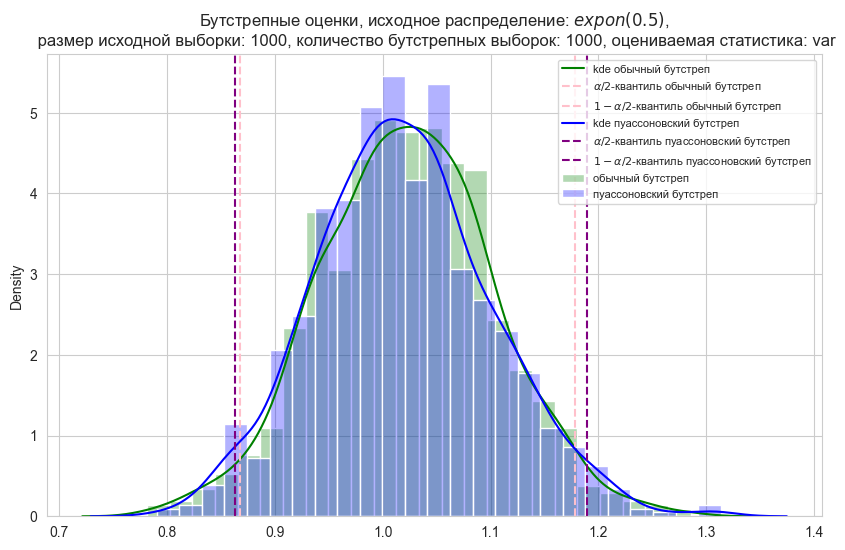

In [77]:
N = 10 ** 3
B = 10 ** 3
X = sps.expon(0.5).rvs(size=N)

stat = np.var
_, b_est = bootstrap(X, B, stat)
_, p_b_est = poisson_bootstrap(X, B, stat, precalc_poisson)
draw_b_est_distr([b_est, p_b_est], labels=['обычный бутстреп', 'пуассоновский бутстреп'], size=N, B=B, distr=r'$expon(0.5)$', stat='var')

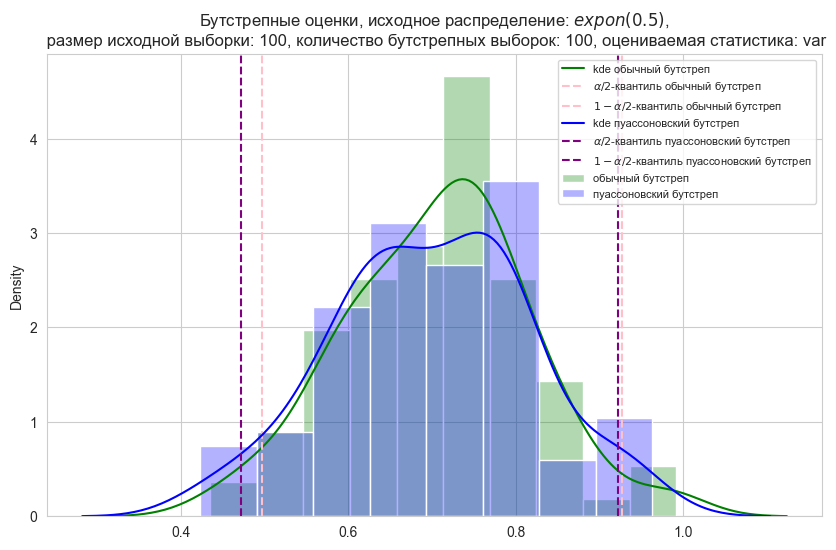

In [83]:
N = 10 ** 2
B = 10 ** 2
X = sps.expon(0.5).rvs(size=N)

stat = np.var
_, b_est = bootstrap(X, B, stat)
_, p_b_est = poisson_bootstrap(X, B, stat, precalc_poisson)
draw_b_est_distr([b_est, p_b_est], labels=['обычный бутстреп', 'пуассоновский бутстреп'],  size=N, B=B, distr=r'$expon(0.5)$', stat='var')

На обычных данных сильного изменений дисперсии не наблюдается, на размере совокупности 100-1000 небольшие изменения видны,  
но интервалы в целом ведут себя не очень стабильно на небольших выборках, поэтому это может быть даже погрешностью.  
Давайте напишем тест на основе бутстрепа и провалидируем его, чтобы разобраться, влияет ли использование пуассоновского бутстрепа на корректность интервалов.

In [16]:
def bootstrap_test(X1, X2, B, b_type='casual', stat=np.mean, stat_fast=lambda x, w, axis=1: np.mean(x * w, axis=axis), poiss=None, interval_type='percentile', alpha=0.05):
    if b_type == 'casual':
        b_est1, b_est2 = bootstrap(X1, B, stat=stat)[1], bootstrap(X2, B, stat=stat)[1]
    elif b_type == 'poisson':
        b_est1, b_est2 = poisson_bootstrap(X1, B, stat=stat, poiss=poiss)[1], poisson_bootstrap(X2, B, stat=stat, poiss=poiss)[1]
    elif b_type == 'poisson_fast':
        b_est1, b_est2 = poisson_bootstrap_fast(X1, B, stat=stat, stat_fast=stat_fast, poiss=poiss)[1], \
                        poisson_bootstrap_fast(X2, B, stat=stat, stat_fast=stat_fast, poiss=poiss)[1]
    else:
        raise Exception('Incoorrect bootstrap_type')
    
    get_interval = {'normal': get_normal_interval,
                    'central': get_central_interval, 
                    'percentile': get_percentile_interval}
    if not interval_type in get_interval.keys():
        raise Exception('Incoorrect interval_type')
    
    b_est = b_est1 - b_est2
    interval = get_interval[interval_type](stat(X1) - stat(X2), None, stat=stat, b_est=b_est, alpha=alpha)
    return not (interval[0] < 0 < interval[1])

Чтобы провалидировать наши бутстрепные тесты напишем фукнцию АА теста.

In [13]:
def draw_alpha_plot(calc_alpha, left_alpha, right_alpha, t_alpha, params):
    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(9, 3))
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(t_alpha, -1, 1, color='r', lw=5, linestyle='--', alpha=0.6, label=r'Целевое значение $\alpha$')
        plt.fill_between([left_alpha, right_alpha], [0.15] * 2, [-0.15] * 2, color='g', alpha=0.6, label=r'Доверительный интервал для $\alpha$')
        plt.scatter(calc_alpha, 0, s=300, marker='*', color='r', label=r'Наблюдаемое $\alpha$')
        plt.xlim((min(t_alpha, left_alpha) - 0.005, max(t_alpha, right_alpha) + 0.005))
        plt.ylim((-0.5, 0.5))
        plt.title('N: {}, B: {}, n_iter: {}, тип интервала: {}, типа бутстрепа: {}'.format(\
            params['N'], params['B'], params['n_iter'], params['int_type'], params['b_type']))
        plt.yticks([])
        plt.legend()
        plt.show()

In [14]:
def AA_test(distr, N=10 ** 3, B=10 ** 3, n_iter=10 ** 3, b_type='casual', stat=np.mean, stat_fast=lambda x, w, axis=1: np.mean(x * w, axis=axis), poiss=None, interval_type='percentile', alpha=0.05):
    errors = 0
    for _ in range(n_iter):
        X1, X2 = distr.rvs(size=N), distr.rvs(size=N)
        errors += bootstrap_test(X1, X2, B, b_type, stat, stat_fast, poiss, interval_type, alpha)
    
    calc_alpha = errors / n_iter
    left_alpha, right_alpha = proportion_confint(errors, n_iter, method='wilson')
    draw_alpha_plot(calc_alpha, left_alpha, right_alpha, alpha, {'N': N, 'B': B, 'n_iter': n_iter, 'int_type': interval_type, 'b_type': b_type})


Формула интервала Уилсона, который используется для построения доверительного интервала для $\alpha$:  
$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{ z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$

Для начала посмотрим, как работает оценка среднего для нормального распределения

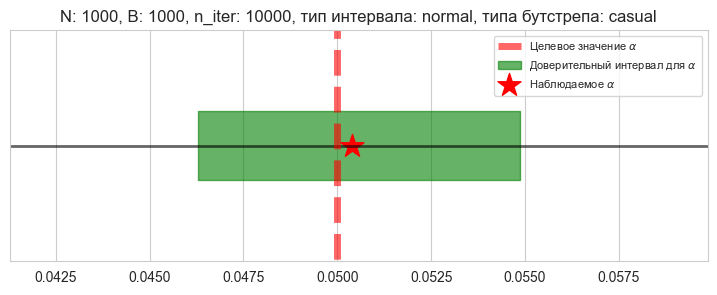

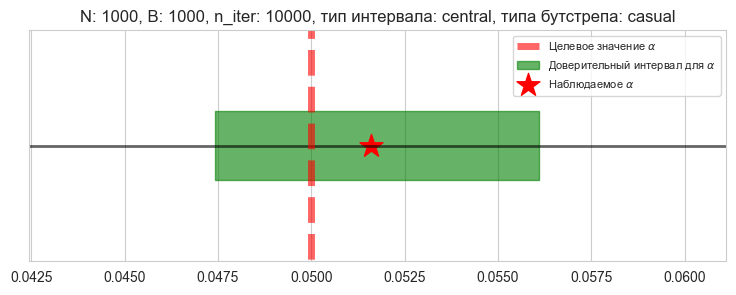

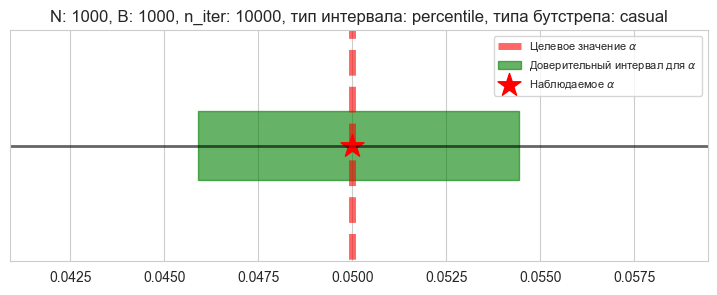

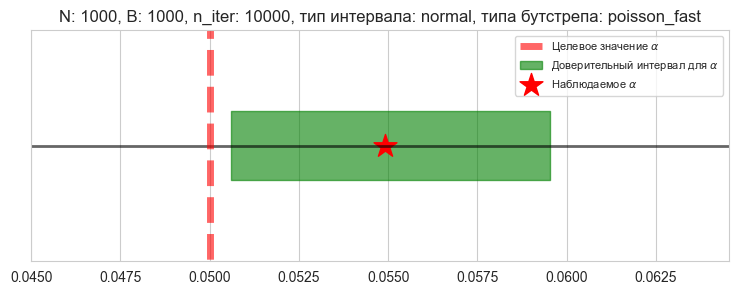

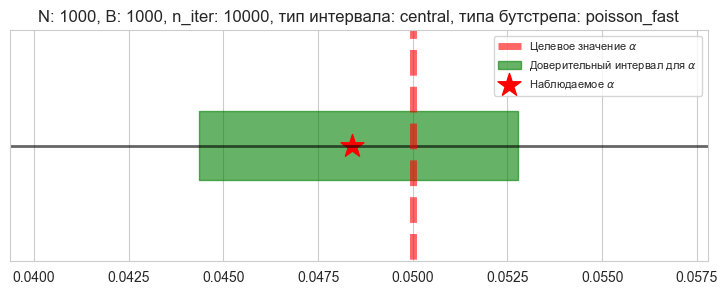

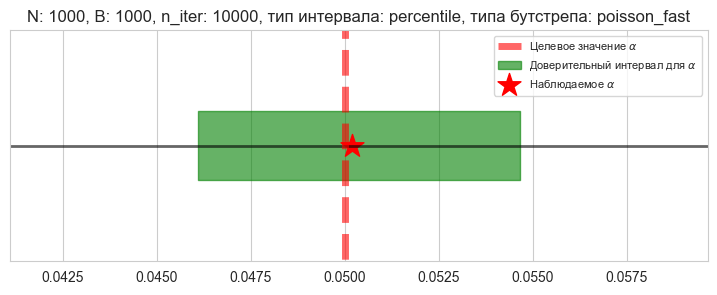

In [172]:
b_type = ['casual', 'poisson_fast']
interval_type = ['normal','central', 'percentile']
bootstrap_params = {'N': 10 ** 3, 'B': 10 ** 3, 'n_iter': 10 ** 4, \
                    'b_type': 'casual', 'stat': np.mean, \
                    'stat_fast': lambda x, w, axis=1: np.mean(x * w, axis=axis), \
                    'poiss': precalc_poisson, 'interval_type': 'central'}

for b_type_, interval_type_ in itertools.product(b_type, interval_type):
    bootstrap_params['b_type'] = b_type_
    bootstrap_params['interval_type'] = interval_type_
    AA_test(sps.norm, **bootstrap_params)

В целом тесты со всеми видами интервалов работают корректно, использование пуассоновского бутстрепа не увеличивает вероятность получения ошибки первого рода.  
Возможно в случае использования нормального доверительного интервала в пуассоновском бутстрапе  
нам сильно не повезло с точечной оценкой, из-за чего немного сместился интервал на $\alpha$,  
в любом случае отличие наблюдаемого $\alpha$ от целевого небольшое.

Теперь попробуем оценить дисперсию

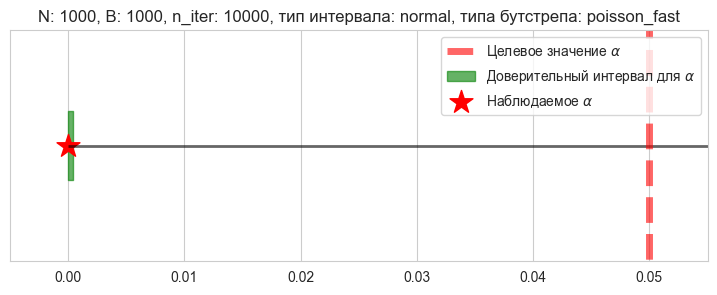

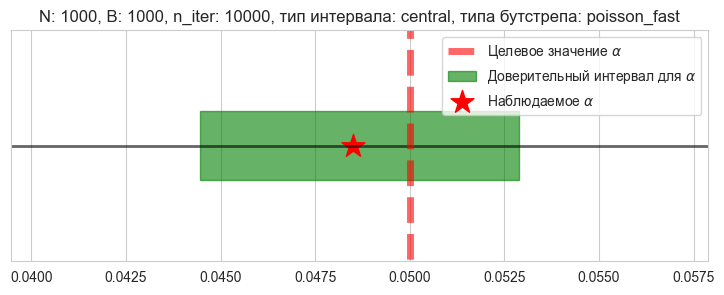

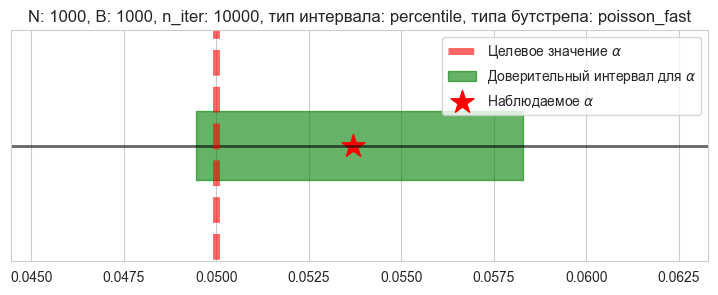

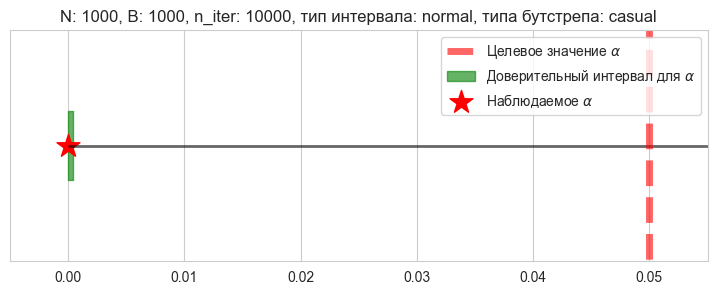

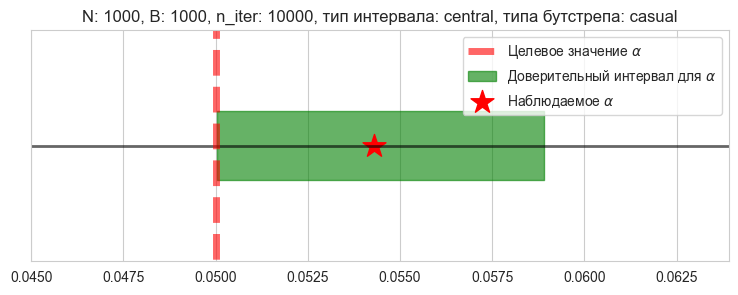

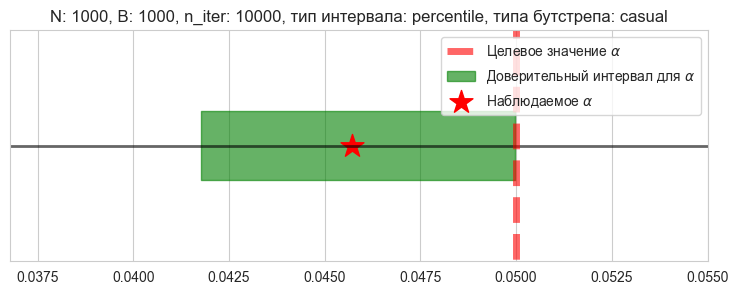

In [39]:
b_type = ['poisson_fast', 'casual']
interval_type = ['normal','central', 'percentile']
bootstrap_params = {'N': 10 ** 3, 'B': 10 ** 3, 'n_iter': 10 ** 4, \
                    'b_type': 'casual', 'stat': np.var, \
                    'stat_fast': lambda x, w, axis=1: np.mean(np.square(x) * w, axis=axis) - np.square(np.mean(x * w, axis=axis)), \
                    'poiss': precalc_poisson, 'interval_type': 'central'}

for b_type_, interval_type_ in itertools.product(b_type, interval_type):
    bootstrap_params['b_type'] = b_type_
    bootstrap_params['interval_type'] = interval_type_
    AA_test(sps.norm, **bootstrap_params)

Здесь мы видим, что нормальный доверительный интервал вероятно плохо подходит для оценки дисперсии, остальные работают корректно.  
Отсутствие ошибок первого рода - это конечно хорошо, но обычно это ведет к низкой мощности теста.

Теперь вернемся к статистике для который доверительные интервалы значительно отличались - среднее значение модуля.

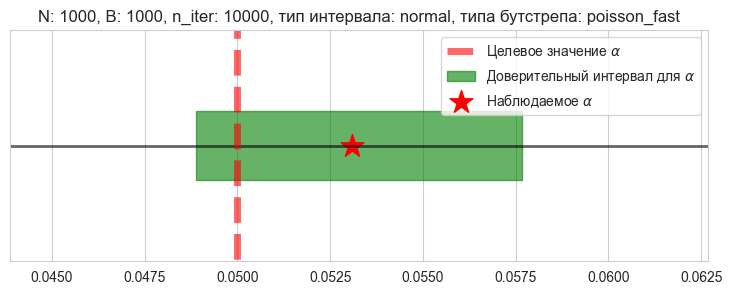

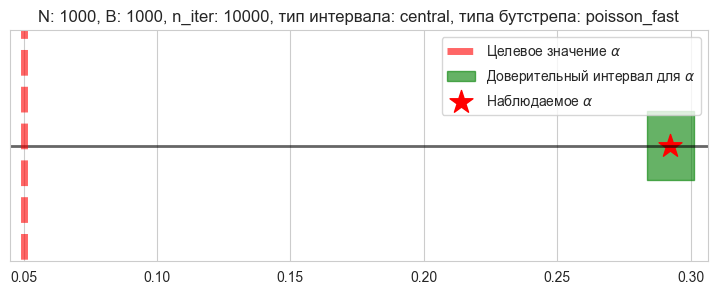

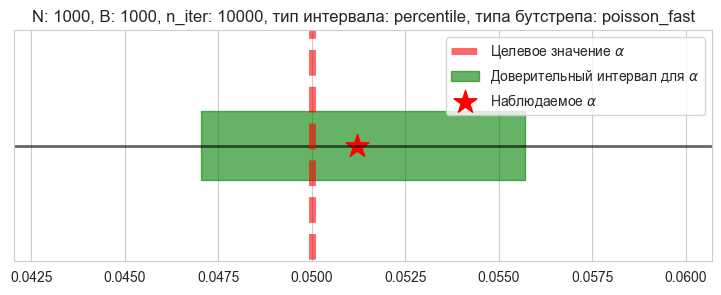

In [43]:
b_type = ['poisson_fast']
interval_type = ['normal','central', 'percentile']
bootstrap_params = {'N': 10 ** 3, 'B': 10 ** 3, 'n_iter': 10 ** 4, \
                    'b_type': 'casual', 'stat': lambda x, axis=None: np.mean(np.abs(x), axis=axis), \
                    'stat_fast': lambda x, w, axis=1: np.mean(np.abs(x) * w, axis=axis), \
                    'poiss': precalc_poisson, 'interval_type': 'central'}

for b_type_, interval_type_ in itertools.product(b_type, interval_type):
    bootstrap_params['b_type'] = b_type_
    bootstrap_params['interval_type'] = interval_type_
    AA_test(sps.norm(0, 10), **bootstrap_params)

Видим, что в данном случае тест с использование центрального доверительного интервала работает некорректно, а остальные интервалы подходят.

Ноутбук уже получился большим, поэтому я решил разделить его на 2 части.  
В следующем ноутбуке будет небольшой обзор мощности бутстрепа, а так же попытка  
применить формулу MDE из T-теста для бутстрепа.

Главный вывод, по этому ноутбуку - при использовании бутстрепа для тестирования гипотез нужно  
аккуратно подходить к выбору доверительного интервала на стадии валидации теста.  
Приведенные выше примеры показывают, что в зависимости от данных некоторые интервалы могут работать некорректно.  

Бонус будет во второй части